1. Import some relevant packages and read data

In [10]:
# Defind some useful packages 
import numpy as np
import pandas as pd
import warnings
import random
import math
import sympy
import ib_insync
from sympy import *
from sympy.stats import Probability, Normal
from arch import arch_model
from scipy.stats import norm
from scipy.optimize import minimize
from pynverse import inversefunc
import matplotlib.pyplot as plt
from pycopula.copula import ArchimedeanCopula
from ib_insync import *
util.startLoop()
#from scipy import special
#from scipy import *
warnings.filterwarnings('ignore')
#read and import data
#data = pd.read_csv('C:/Users/Zhou Jiahao/data.csv').set_index('Unnamed: 0')

In [11]:
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=2)

<IB connected to 127.0.0.1:7497 clientId=2>

Requests historical data from TWS. (last 30 days, interval = 5 mins)

In [12]:
contract1 = Stock('HPE', 'SMART', 'USD')
contract2 = Stock('NOK', 'SMART', 'USD')
contract3 = Stock('CIEN', 'SMART', 'USD')
contract4 = Stock('UI', 'SMART', 'USD')
contract5 = Stock('MSI', 'SMART', 'USD')
#contract6 = Index('NYA', 'PSE', 'USD')    #MSCI不能包括进去 不然计算copula的参数时会报错（维度对不上）
hpe = ib.reqHistoricalData(contract1,endDateTime='',durationStr='200 D',barSizeSetting='1 hour',whatToShow='TRADES',useRTH=True,formatDate=1)
nok = ib.reqHistoricalData(contract2,endDateTime='',durationStr='200 D',barSizeSetting='1 hour',whatToShow='TRADES',useRTH=True,formatDate=1)
cien = ib.reqHistoricalData(contract3,endDateTime='',durationStr='200 D',barSizeSetting='1 hour',whatToShow='TRADES',useRTH=True,formatDate=1)
ui = ib.reqHistoricalData(contract4,endDateTime='',durationStr='200 D',barSizeSetting='1 hour',whatToShow='TRADES',useRTH=True,formatDate=1)
msi = ib.reqHistoricalData(contract5,endDateTime='',durationStr='200 D',barSizeSetting='1 hour',whatToShow='TRADES',useRTH=True,formatDate=1)
#msci = ib.reqHistoricalData(contract6,endDateTime='',durationStr='200 D',barSizeSetting='1 hour',whatToShow='TRADES',useRTH=True,formatDate=1)

In [13]:
df1 = util.df(hpe)
df2 = util.df(nok)
df3 = util.df(cien)
df4 = util.df(ui)
df5 = util.df(msi)
#df6 = util.df(msci)    
df=[df1['close'],df2['close'],df3['close'],df4['close'],df5['close']]   # ,df6['close']  删了MSCI的部分
df=pd.DataFrame(df)
df = df.T
df.columns = ['HPE','NOK','CIEN','UI','MSI']    #['HPE','NOK','CIEN','UI','MSI','MSCI']
display(df3)

,date,open,high,low,close,volume,average,barCount
0,2019-04-17 14:30:00,39.11,39.21,38.65,38.69,2636,38.922,1142
1,2019-04-17 15:00:00,38.69,38.80,38.55,38.56,2800,38.683,1840
2,2019-04-17 16:00:00,38.55,38.73,38.45,38.46,3748,38.598,1970
3,2019-04-17 17:00:00,38.45,38.50,38.20,38.30,3521,38.313,1852
4,2019-04-17 18:00:00,38.31,38.48,38.25,38.37,1555,38.353,1091
...,...,...,...,...,...,...,...,...
1386,2020-01-31 16:00:00,40.96,41.07,40.60,41.01,2001,40.851,1284
1387,2020-01-31 17:00:00,41.01,41.08,40.64,40.70,1022,40.850,651
1388,2020-01-31 18:00:00,40.70,40.81,40.60,40.72,1798,40.690,912
1389,2020-01-31 19:00:00,40.73,40.95,40.62,40.87,1850,40.769,1067


Calculate assets' compound returns

,HPE,NOK,CIEN,UI,MSI
0,0.006649,0.001726,-0.003366,0.001081,-0.002759
1,-0.001206,0.001723,-0.002597,0.003058,-0.003528
2,0.000603,-0.003448,-0.004169,-0.005312,0.000831
3,0.003009,0.008599,0.001826,0.003514,-0.001317
4,-0.005423,0.003419,0.004940,0.000450,-0.002430
...,...,...,...,...,...
786,-0.000683,0.000000,-0.001275,0.007423,0.000522
787,0.016261,0.017840,0.001020,-0.004739,-0.006169
788,0.010030,-0.001967,0.014170,-0.007029,0.001108
789,-0.001998,-0.005923,-0.002012,0.003123,-0.001692


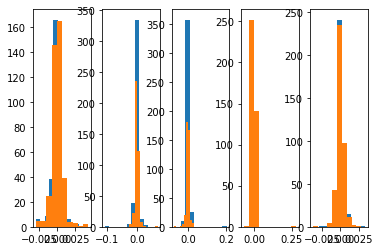

In [14]:
returns = np.log(df / df.shift(1))
returns = returns.dropna()
returns = returns.reset_index(drop = True)
display(returns)

a = returns.shape[0] 
# Check invariance: [Heuristic Test] compare split sample histograms
for i in range(5):
    a1=returns.iloc[:a//2,i]
    a2=returns.iloc[a//2+1:,i]
    plt.subplot(1,5,i+1)
    plt.hist(a1)
    plt.hist(a2)

data = returns    #黄丹烨读数据用的是returns 吴周代码中用的是data 所以 returns ---> data

2. Calculate the rates of return

In this case, we use logarithmic rates of return:
$$r_i =\ln (p_t)_i - \ln(p_{t-1})_i,\qquad i=1,2,3,4,5$$ 

In [15]:
# 代码将价格转换为对数收益率

3. Find Cumulative Distribution Functions (CDFs) of each rates of return

There are lots of methods to fit CDF of each rates of return, such as normal distribution and student t-distribution. However, in general, the rate of return has some properties, like heteroscedasticity. Therefore, we use Garch(1,1) to modify their distributions.

The Garch (1,1) module:

$$
\left\{
\begin{aligned}
r_t &= \mu+a_t \\
a_t &= \sigma _t \varepsilon_t, \qquad \varepsilon_t \sim N(0,1)\\
\sigma^2_t &= \alpha_0 + \alpha_1 a^2_{t-1}+\beta \sigma^2_{t-1} \\
\end{aligned}
\right.
$$

Then, we can get conditional CDFs of each stock based on the Garch(1,1) module:

$$
\begin{aligned}
P\{r_{t+1}|\Omega_t\} &= P\{a_{t+1} \leqslant (r-\mu)|\Omega_t\}\\
&= P\{ \sigma _{t+1} \varepsilon_{t+1} \leqslant (r-\mu)|\Omega_t\}\\ 
&= P\{\varepsilon_{t+1} \leqslant \frac{r-\mu}{\sqrt{\alpha_0 + \alpha_1 a^2_{t}+\beta \sigma^2_{t}}}\},\qquad \varepsilon_t \sim N(0,1)
\end{aligned}
$$

Hence, we can get CDFs of each stock. 

In [16]:
#Calculate arch model parameter values
def get_arch_params(data_temp):
    am = arch_model(data_temp)
    #data['log_re_HPE'] = np.log(data['HPE'])   #There are many data for taking the log return rate as 0, and a missing process needs to be added.
    model = am.fit(update_freq = 0)
    mu  = model.params[0]
    omega = model.params[1]
    alpha = model.params[2]
    beta = model.params[3]
    return [mu, omega, alpha, beta]

In [17]:
grach_params =[]
a_t = []
c_t = []
for i in range(5):
    data_ready = data.iloc[:,i]
    grach_params.append(get_arch_params(data_ready))
    a_t.append(data_ready.to_list()[-1]) 
    c_t.append(data_ready.var()) 
    
grach_params

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2809.017667500593
            Iterations: 11
            Function evaluations: 94
            Gradient evaluations: 7
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2763.3544794910617
            Iterations: 11
            Function evaluations: 81
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2476.3865700275105
            Iterations: 5
            Function evaluations: 51
            Gradient evaluations: 4
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -2002.0482051346066
            Iterations: 13
            Function evaluations: 124
            Gradient evaluations: 9
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3072.7103008124304
          

D:\Anaconda3\lib\site-packages\arch\univariate\base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
D:\Anaconda3\lib\site-packages\arch\univariate\base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
D:\Anaconda3\lib\site-packages\arch\univariate\base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
D:\Anaconda3\lib\site-packages\arch\univariate\base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


[[-0.00010420823599719388,
  9.930720148684127e-07,
  0.010000123407897393,
  0.970000003545694],
 [-0.0002032918163732849,
  2.6843244920771784e-05,
  0.009999012823547352,
  0.49005134112255455],
 [-4.761239056913784e-05,
  3.351378065358757e-05,
  0.00999980793687117,
  0.6900059474944323],
 [0.014039809803647108,
  2.8495775275565147e-06,
  0.10000234074079163,
  0.8799961667127683],
 [0.0002260235524356561,
  5.014446573079101e-07,
  0.010000029637956327,
  0.9700000008981199]]

4. Using Clayton copula to find Joint Cumulative Distribution Function(CDF)

The expression of Clayton copula is that:
$$
C(\mu_1,\mu_2,\mu_3,\mu_4,\mu_5) = [\sum ^{5}_{i=1} \mu_i^{-\theta}-5+1]^{-\frac{1}{\theta}},\qquad \theta>0 
$$

In [18]:
archimedean = ArchimedeanCopula(family="clayton", dim=5)
theta = archimedean.fit(data.values, method="cmle",verbose = True)[0]

5. Monte Carlo Simulation

After all parameters of the copula $C(u_1, u_2, u_3, u_4, u_5)$ are known, we use the method of conditional distributions to generate series of variables. 

Firstly, let $C_{u_1}$ denotes the conditional distribution function for the random variable $u_2$ at a given value $u_1$ of the two-dimensional copula $C(u_1, u_2)$, with the following expression: 
$$C_{u_1}(u_2)=\frac{\partial C(u_1, u_2)}{\partial u_1}$$ 
In addition, $C_{u_1}$ are non-decreasing almost everywhere on $[0,1]$. Similarly, the function: 
$$u_2 \rightarrow C_{u_1}(u_2)=\frac {\partial C(u_1, u_2)}{\partial u_1}$$
is also uniformly distributed on $[0,1]$.

Therefore, in general, for k-dimension copula $C(u_1, u_2, ..., u_k)$, the k-1 steps conditional distribution function:
$$u_k \rightarrow C_{u_1 u_2...u_{k-1}}(u_k)=\frac {\partial C(u_1, u_2, ..., u_k)} { \partial u_1 \partial u_2 \partial u_{k-1}}$$
is uniformly distributed on $[0,1]$.

Secondly, in order to generate random numbers, we need the following theorem:

Let $C(u_1, u_2, ..., u_k) = \varphi^{-1}(\varphi(u_1)+\varphi(u_2)+...+\varphi(u_k))$ be an Archimedean n-variate copula with generator $\varphi(\cdot)$,

\begin{equation}
\begin{aligned}
C_k(u_k|u_1,...,u_{k-1}) = \frac{\varphi^{-1 (k-1)}(\varphi(u_1)+\varphi(u_2)+...+\varphi(u_k))}{\varphi^{-1 (k-1)} (\varphi(u_1)+\varphi(u_2)+...+\varphi(u_{k-1}))},\qquad k=2,3,...,n 
\end{aligned}
\end{equation}

In following process, we should declare:

\begin{equation}
\begin{aligned}
\varphi ^{-1 (k)}(t) = (-1)^k \frac{(\theta+1)(\theta+2).....(\theta+k-1)}{\theta^k}(t+1)^{-\frac{1}{\theta}-k}
\end{aligned}
\end{equation}

The following algorithm generates a random variate $(u_1, u_2,.., u_5)'$ from Clayton copula:

$\qquad \cdot$ Simulate n independent random variables $(v_1, v_2,.., v_5)'$ from $U(0,1)$

$\qquad \cdot$ Set $u_1 = v_1$

$\qquad \cdot$ Set $v_2 = C_2(u_2|v_1)$ Hence, we get that:

\begin{equation}
\begin{aligned}
v_2 &= \frac{\varphi ^{-1 (1)}(c_2)}{\varphi ^{-1 (1)}(c_1)} = \left ( \frac{u_1^{- \theta} + u_2^{- \theta} - 1}{u_{1}^{-\theta}} \right )^{-\frac{1}{\theta}-1}
\end{aligned}
\end{equation}

So
\begin{equation}
\begin{aligned}
u_2 = \left ( v_1^{- \theta} ( v_2^{- \frac{\theta}{\theta + 1}} - 1 ) + 1 \right )^{-\frac{1}{\theta}}
\end{aligned}
\end{equation} 


$\qquad \cdot$ Then
\begin{equation}
\begin{aligned}
v_3 = C_3(u_3|u_1, u_2)= \frac{\varphi ^{-1 (2)}(c_3)}{\varphi ^{-1 (2)}(c_2)}
\end{aligned}
\end{equation} 


......


$\qquad \cdot$ In general, solve in $u_n$ the equation
\begin{equation}
\begin{aligned}
v_n = \left ( \frac{u_1^{- \theta} + u_2^{- \theta} + ... + u_n^{- \theta} +-n+1}{u_1^{- \theta} + u_2^{- \theta} + ... + u_{n-1}^{- \theta} +-n+2} \right )^{-\frac{1}{\theta}-n+1}
\end{aligned}
\end{equation} 

$\qquad \cdot$ So we have
\begin{equation}
\begin{aligned}
u_n = \left \{ (u_1^{- \theta} + u_2^{- \theta} + ... + u_{n-1}^{- \theta} +-n+2) \cdot \left ( v_n^{\frac{\theta}{\theta(1-n)-1}} \right ) +1 \right \}^{-\frac{1}{\theta}}
\end{aligned}
\end{equation} 

Now, we have generated random numbers for m groups $(u_1, u_2, u_3, u_4, u_5)^{m}$, where m is the number of Monte Carlo simulations

Finally, we can use Quantile $F^{-1}(\cdot)$ to the get the simulated returns:
\begin{equation}
\begin{aligned}
r_i^{j} = F^{-1}(u_i^j) \quad \quad i = 1,2,...,5 ，\qquad j = 1,2,...,m
\end{aligned}
\end{equation}

In [19]:
#生成随机数v
v = [[],[],[],[],[]]
for i in range(5):
    for j in range(1000):
        x = random.uniform(0,1)
        v[i].append(x)

In [20]:
#计算u的模拟值
u = [[],[],[],[],[]]
u[0] = v[0]
#theta = 0.12 #在copula中获得
for i in range(1000):
    x = ((v[0][i] ** (-theta)) * (v[1][i] ** (-theta / (1 + theta)) - 1) + 1) ** (- 1 / theta)
    u[1].append(x)

for i in range(1000):
    x = ((u[0][i] ** (-theta) + u[1][i] ** (-theta) - 3) * (v[2][i] ** (theta / (- 4 * theta - 1)) - 1) + 1) ** (-1/theta)
    u[2].append(x)

for i in range(1000):
    x = ((u[0][i] ** (-theta) + u[1][i] ** (-theta) + u[2][i] ** (-theta) - 3) * (v[3][i] ** (theta / (- 4 * theta - 1)) - 1) + 1) ** (-1/theta)
    u[3].append(x)

for i in range(1000):
    x = ((u[0][i] ** (-theta) + u[1][i] ** (-theta) + u[2][i] ** (-theta) + u[3][i] ** (-theta) - 3) * (v[4][i] ** (theta / (- 4 * theta - 1)) - 1) + 1) ** (-1/theta)
    u[4].append(x)
    

In [21]:
#中间变量累计密度函数的反函数
u_ppf = [[],[],[],[],[]]
#累计密度函数
for i in range(5):
    for j in range(1000):
        u_ppf[i].append(norm.ppf(u[i][j]))

In [22]:
#生成模拟收益率（函数取反）
r_simulation = [[],[],[],[],[]]
for i in range(5):
    function_r_adj = (lambda x : (x - grach_params[i][0])/((grach_params[i][1] + grach_params[i][2] * (a_t[i] ** 2) + grach_params[i][3] * (c_t[i] ** 2)) ** 0.5))
    inv_func_r_adj = inversefunc(function_r_adj)
    for j in range(1000):
        r_simulation[i].append(inv_func_r_adj(u_ppf[i][j]).tolist())

6. Estimate Cvar

After Monte Carlo Simulation, we have got five-dimension rates of return, which represents random variables of each stocks in the future. Then we can calculate Cvars of each stock based on the definition of Cvar, such that:

$\qquad\cdot$ Calculate 1% quantile of each stock

$\qquad\cdot$ Intercept the data before 1% quantile of each stock

$\qquad\cdot$ Calculate the mean of intercepted data as Cvar of each stock


In [23]:
VaR = []
CVaR = []
for i in range(5):
    r_sim_sorted = sorted(r_simulation[i])
    VaR.append(r_sim_sorted[math.floor((len(r_simulation[i])*(1 - 0.99)) - 1)])
    CVaR.append(np.mean(r_sim_sorted[:math.floor((len(r_simulation[i])*(1 - 0.99)) - 1)]))

7. Find optimal weights of each stock

In order to find optimal weights of each stock in a portfolio, we can build a optimization system, such that:

$$
Max \sum_{i=1}^{5} \omega_{i} r_i\\
\begin{aligned}
s.t. Cvar(\sum_{i=1}^{5} \omega_{i} r_i) &\geq -1\% \\
\sum_{i=1}^{5} \omega_{i} &= 1
\end{aligned}
$$

However, it is difficult to estimate Cvar of portfolio. Therefore, according to the subadditivity and homogeneity of Cvar, we can transfer the first constraint condition to that:
$$
\begin{aligned}
Cvar(\sum_{i=1}^{5} \omega_{i} r_i) &\leqslant \sum_{i=1}^{5} Cvar(\omega_{i} r_i)\\
&= \sum_{i=1}^{5} \omega_{i} Cvar( r_i)
\end{aligned}
$$

Hence, the new optimization system is that:
$$
Max \sum_{i=1}^{5} \omega_{i} r_i\\
\begin{aligned}
s.t. \sum_{i=1}^{5} \omega_{i} Cvar( r_i) &\geq -1\% \\
\sum_{i=1}^{5} \omega_{i} &= 1
\end{aligned}
$$

Finally, it is a linear optimization system, which can simply be solved. 

In [24]:
weights = []
for i in range(len(data)):
    e = 1e-10 
    fun = lambda x : -(x[0] * data.values[i][0] + x[1] * data.values[i][1] + x[2] * data.values[i][2] + x[3] * data.values[i][3] + x[4] * data.values[i][4])# 约束函数
    cons = ({'type': 'eq', 'fun': lambda x: x[0] + x[1] + x[2] + x[3] + x[4] - 1}, 
            {'type': 'ineq', 'fun': lambda x: x[0] - e}, 
            {'type': 'ineq', 'fun': lambda x: x[1] - e},
            {'type': 'ineq', 'fun': lambda x: x[2] - e},
            {'type': 'ineq', 'fun': lambda x: x[3] - e},
            {'type': 'ineq', 'fun': lambda x: x[4] - e},
            {'type': 'ineq', 'fun': lambda x: 0.01 + x[0] * CVaR[0] + x[1] * CVaR[1] + x[2] * CVaR[2] + x[3] * CVaR[3] + x[4] * CVaR[4] - e})
        
    x0 = np.array((0.2, 0.2, 0.2, 0.2, 0.2)) 
    res = minimize(fun, x0, method='SLSQP', constraints=cons)
    weights.append(res.x)
    
weight = weights[0]
print(weight)

[1.00000000e+00 9.99999250e-11 9.99997058e-11 1.00000394e-10
 9.99998192e-11]
